# Descriptive Data Analysis of Insurance dataset

We will be using Mobiliar insurance dataset. We have to select features we are going to consider for our analysis as well as devise a plan to aggregate data on zip-code level.

First of all, we are going to read the dataset and visualize its features:

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
DATA_DIR = './data/'

In [3]:
zurich_df = pd.read_pickle(DATA_DIR + 'zurich_insurance.pkl')

In [4]:
# look at features available & data type
zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car1_Canton', 'Car1_Brand',
       'Car1_Class', 'Car1_Price', 'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y',
       'Car1_ClaimsSum5Y', 'Car2_Canton', 'Car2_Brand', 'Car2_Class',
       'Car2_Price', 'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y',
       'Car2_ClaimsSum5Y', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS'],
      dtype='object')

We will only keep number of cars, total car price and total premium with regard to cars and drop other values

In [5]:
# person's ownership of cars: 
# The information we want: # car, total car price, total car premium
# aggregate # car
zurich_df['num_cars'] = (zurich_df['Car1_Price'] > 0).astype(int) + (zurich_df['Car2_Price'] > 0).astype(int)

# aggregate total car price
zurich_df['total_car_spending'] = zurich_df['Car1_Price'] + zurich_df['Car2_Price']

zurich_df = zurich_df.drop(['Car1_Canton', 'Car1_Brand','Car1_Class', 'Car1_Price', \
                            'Car1_1Imtr', 'Car1_ccm', 'Car1_ClaimsCt5Y','Car1_ClaimsSum5Y', \
                            'Car2_Canton', 'Car2_Brand', 'Car2_Class', 'Car2_Price',\
                            'Car2_1Imtr', 'Car2_ccm', 'Car2_ClaimsCt5Y', 'Car2_ClaimsSum5Y'], axis=1)

zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car_Premium', 'HH_Zip', 'HH_Ins_Sum',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'Build_Ins_Sum',
       'HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS',
       'num_cars', 'total_car_spending'],
      dtype='object')

We will also keep location, number of rooms and standard of furniture (categorical variable) as well as add a new feature that will represent sum of premium on house/building. Other features regarding ownership properties will be dropped.

In [6]:
# person's ownership of properties: 
# keep: location of house & building, # rooms, standard of furniture, sum(premium on hourse/building)
zurich_df['property_premium'] = zurich_df['HH_Ins_Sum'].astype(int) + zurich_df['Build_Ins_Sum'].astype(int)
zurich_df = zurich_df.drop(['HHaB_ClaimsCt5Y', 'HHaB_ClaimsSum5Y', 'HH_and_Bld_Prem.', 'BFS', 'HH_Ins_Sum', 'Build_Ins_Sum'], axis=1)
zurich_df.columns

Index(['JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang',
       'Nation', 'ZIP', 'Children_0-26', 'Car_Premium', 'HH_Zip',
       'Stand_of_furn', 'Rooms', 'Build_Zip', 'num_cars', 'total_car_spending',
       'property_premium'],
      dtype='object')

Since we have many different nationalities, we will group them into two categories: 1) Swiss and 2) non Swiss. We might consider more fine grained grouping if needed during analysis

In [7]:
# change Nation to Swiss vs Non-Swiss
zurich_df['Nation'] = zurich_df['Nation'].apply(lambda x : x.strip())
zurich_df['is_swiss'] = (zurich_df['Nation'] == 'CH').astype(str)

Then we will identify categorical variables, as well as derive new features such as age (using current and birth year), as well as well as adjust types for some of the features.

In [8]:
# convert 'JobState', 'Job', 'Civil', 'YearOfBirth', 'Gender', 'Own/Rent', 'Lang', 'Nation' to categorical data
for col in ['JobState', 'Job', 'Civil', 'Gender', 'Own/Rent', 'Lang', 'Nation']:
    zurich_df[col] = zurich_df[col].astype('category')

In [9]:
# calculate age of insurer, also convert the type of standard of furniture & # rooms
zurich_df['Age'] = 2018 - zurich_df['YearOfBirth']
zurich_df['Stand_of_furn'] = zurich_df['Stand_of_furn'].apply(lambda x : '0' if x.strip() == '' else x.strip()).astype(int)
zurich_df['Rooms'] = zurich_df['Rooms'].apply(lambda x : '0' if x.strip() == '' or x.strip() == 'NA' else x.strip()).astype(float)

### Aggregate the data of the entries per area (can be one zip code area or Zurich as a whole)
###### For categorical data, we calculate the percentage of each category
###### For numerical data, we calculate the average

In [10]:
def aggregate_categorical_map(df):
    '''
    given a dataframe, aggregate the categorical data that we want to study
    return a map of the form:
    category -> {subcategory1: percentage.ect}
    '''
    aggregation = {}
    total = df.shape[0]
    for col in ['JobState', 'Civil', 'Gender', 'Own/Rent', 'Lang', 'is_swiss']:
        aggregation[col] = {}
        for val in df[col].unique():
            key = val.strip()
            if key == '': key = 'Unknown'
            key = '%' + col + '_' + key
            aggregation[col][key] = [100*len(df.loc[df[col] == val])/total]
    return aggregation

In [11]:
def aggregate_numerical_df(df, index):
    '''
    given a dataframe
    return a dataframe where the each column has the average value of that column in the input dataframe
    '''
    num_aggregation = {}
    for col in ['Children_0-26', 'Car_Premium', 'num_cars', 'total_car_spending', 'property_premium', 'Age', 'Stand_of_furn', 'Rooms']:
        avg = zurich_df[col].mean()
        num_aggregation['Avg_'+col] = [avg]    
    return pd.DataFrame(num_aggregation, index=index)

In [12]:
# visualize the categorical aggregation data for Zurich
agg = aggregate_categorical_map(zurich_df)
for category in agg:
    data_pd = pd.DataFrame.from_dict(agg[category])
    # visualize the dataframe

In [13]:
# present the numerical aggregation data for Zurich
num_agg_df = aggregate_numerical_df(zurich_df, ['Zurich'])
num_agg_df

,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
Zurich,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757


### Group the on the zip code level and study the data for each zip code area

In [14]:
zip_group = zurich_df.groupby('ZIP')
# zipcode -> dataframe
zip_group_dic = {zip_code: df for (zip_code, df) in zip_group}

# all zipcodes
zip_group_dic.keys()

dict_keys(['8001', '8002', '8003', '8004', '8005', '8006', '8008', '8021', '8022', '8024', '8027', '8031', '8032', '8034', '8036', '8037', '8038', '8040', '8041', '8042', '8044', '8045', '8046', '8047', '8048', '8049', '8050', '8051', '8052', '8053', '8055', '8057', '8064', '8098'])

In [15]:
# number of data in each zip code, use to_dict so it's displayed horizontally to save space
data_count = zip_group.size()
print(data_count.to_dict())

{'8001': 691, '8002': 1093, '8003': 2499, '8004': 3326, '8005': 2089, '8006': 2370, '8008': 1960, '8021': 6, '8022': 4, '8024': 10, '8027': 6, '8031': 5, '8032': 2226, '8034': 2, '8036': 6, '8037': 2159, '8038': 2043, '8040': 4, '8041': 701, '8042': 2, '8044': 1299, '8045': 1197, '8046': 2471, '8047': 2418, '8048': 3038, '8049': 2853, '8050': 2751, '8051': 1924, '8052': 1918, '8053': 1274, '8055': 2297, '8057': 2327, '8064': 267, '8098': 6}


In [16]:
# if the zip code area has < 250 entries, we ignore the region
data_count = data_count.to_frame(name='Count')
zip_skip = data_count.loc[data_count['Count'] < 250].index

### Visualize distributions for the entire city of Zurich

In [17]:
df_dic = zip_group_dic
df_dic['Zurich'] = zurich_df
zurich_df.head()

,JobState,Job,Civil,YearOfBirth,Gender,Own/Rent,Lang,Nation,ZIP,Children_0-26,Car_Premium,HH_Zip,Stand_of_furn,Rooms,Build_Zip,num_cars,total_car_spending,property_premium,is_swiss,Age
49,,0000 ...,,1946,,E,D,,8004,0,0.0,8004,0,0.0,8004,0,0,703000,False,72
73,Rentner,0000 ...,Verwitwet,1935,W,M,D,CH,8032,0,0.0,8032,2,3.5,0,0,0,80000,True,83
178,Angestellt,0000 ...,Verheiratet,1942,M,M,D,CH,8048,0,0.0,8048,0,0.0,0,0,0,85000,True,76
398,Rentner,0000 ...,Verheiratet,1938,M,M,D,SV,8038,0,0.0,8038,0,0.0,0,0,0,95000,False,80
503,Angestellt,0000 ...,Ledig,1961,W,M,D,CH,8037,0,0.0,8037,1,2.0,0,0,0,33000,True,57


In [18]:
def plot_numerical(df_to_plot, ncols):
    '''
    This function plots the distribution of the data given in the input using histograms.
    
    Parameters:
    df_to_plot = dataframe of data_to_plot, all columns are plotted
    '''
    nrows= int(1 + df_to_plot.shape[1] // (ncols+0.01))
    
    f, axs = plt.subplots(nrows,ncols,figsize=(16, nrows*4))
    
    for k, col in enumerate(df_to_plot.columns):
        axs[k].hist(df_to_plot[col],bins=20)
        axs[k].grid(color='k', linestyle='-', linewidth=0.2)
        axs[k].set_title(col)

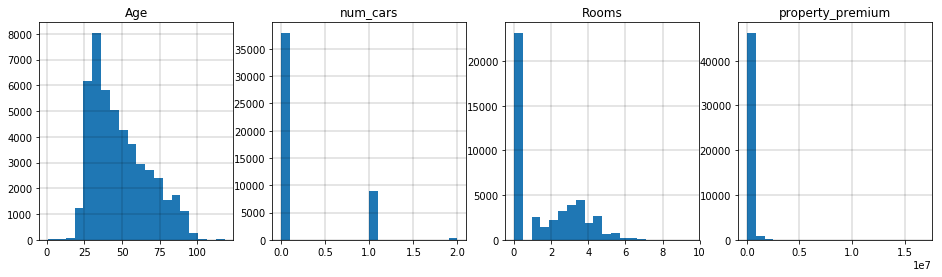

In [19]:
# plotting some of the numerical data
plot_numerical(zurich_df[['Age','num_cars','Rooms','property_premium']],4)

### Aggregate the data for each zip code

##### aggregate numerical data for each zip code area

In [20]:
num_aggregate_all = pd.DataFrame()
for area in df_dic:
    num_aggregate_all = pd.concat([num_aggregate_all, aggregate_numerical_df(df_dic[area], [area])])
num_aggregate_all.head(3)

,Avg_Children_0-26,Avg_Car_Premium,Avg_num_cars,Avg_total_car_spending,Avg_property_premium,Avg_Age,Avg_Stand_of_furn,Avg_Rooms
8001,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757
8002,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757
8003,0.216566,240.99307,0.2045,8172.050294,110386.647475,48.702786,0.799014,1.565757


##### aggregate categorical data for each zip code area

In [21]:
def get_all_categorical_aggregation(df_dic):
    '''
    input: {area -> dataframe of the info the area}
    return: {category -> df of aggregation data of all area (row: zip; col: data)}
    '''
    # category -> df of aggregation data of all area (row: zip; col: data)
    area_agg_by_category = {}
    for area in df_dic:
        if area in zip_skip:
            continue

        aggregation = aggregate_categorical_map(df_dic[area])
        for category in aggregation:
            df = pd.DataFrame.from_dict(aggregation[category])
            df.index = [area+'_']
            if category in area_agg_by_category.keys():
                area_agg_by_category[category] = pd.concat([area_agg_by_category[category], df])
            else:
                area_agg_by_category[category] = df
    for key in area_agg_by_category:
        area_agg_by_category[key] = area_agg_by_category[key].fillna(0.0)
    return area_agg_by_category

In [25]:
area_agg_by_category = get_all_categorical_aggregation(df_dic)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Visualize the aggregated categorical data for each area

In [26]:
def df_to_vis_string(df, file):
    '''
    from dataframe, save to the json format that is acceptable by the javascript visualization module
    '''
    df_dic = {}
    df_dic['y'] = list(df.index)
    df_dic['x'] = list(df.columns)
    df_dic['z'] = []
    df_dic['ygap'] = 1
    df_dic['xgap'] = 2
    df_dic['colorbar'] = {'nticks':12}
    for i in range(df.shape[0]):
        df_dic['z'].append(list(df.iloc[i]))
    df_dic['type'] = 'heatmap'
    if file != '':
        with open(file, 'w') as fp:
            json.dump(df_dic, fp)
    return [df_dic]

In [27]:
# save to file for javascript visualization
for category in area_agg_by_category:
    file = category.replace('/', '_') + '.json'
    df_to_vis_string(area_agg_by_category[category], file)

#### This is an iteractive heatmap visualization. You can load it from jupyternotebook here. Only need to run this one cell

In [28]:
from IPython.display import IFrame
IFrame('vis_js/index_sync.html', width=1000, height=700)